# Preparations

In [197]:
import ast
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (8,6)

In [173]:
# Some parameters of the simulations to be analyzed
rounds = 50
vehicle_limit = 80

rate_range = np.arange(2,66,2)
target_number_of_rounds = 15

all_routes = [[0, 3], [0, 1], [2, 3], [2, 1]]
sub_routes = [[0, 1], [2, 3]]

## Preprocessing of `record`
The dataframe contains vehicle data recorded in each simulation round, including:
- the label assigned to each car (`Vehicle_label`)
- the routes taken (`Road_order`)
- the time spent to reach the end (`Total_time`)
- the label of the vehicle immediately in front of it in the corrdsponding road segment (`Leading_vehicles`)
- the amount of time it stopped (speed is 0) in the corresponding road segment (`Stopped_time`)

In [3]:
def preprocess_record(record, routes):
    # Since some column values are lists, they need to be preprocessed after importing the csv file to
    # avoid the lists being recognized as strings
    record['Road_order'] = record.apply(lambda row: ast.literal_eval(row['Road_order']), axis=1)

    # Add a column that maps a specific road combination (i.e., a route) to a "label", which is its position
    # in a list that shows all the possible routes
    record["Road_order_label"] = record.apply(lambda row: routes.index(row.Road_order), axis=1)
    return record

## Preprocessing of `utility`
The dataframe contains utility data computed based on the simulation outcome, including:
- the label assigned to each car (`Vehicle_label`)
- the utility value of each route as a list element (`Utilities`)
- the probability value of choosing each route in the next round as a list element (`Probabilities`)
- all the routes each car has chosen so far (`Routes_taken`)
- the interpolation between time and money for the driver (`Gamma`) for computing the time component of the utility value
- the risk aversion level of the driver (`Eta`) for deciding the formula of utility calculation

In [4]:
def preprocess_utility(utility):
    # Since some column values are lists, they need to be preprocessed after importing the csv file to
    # avoid the lists being recognized as strings
    utility['Routes_taken'] = utility.apply(lambda row: ast.literal_eval(row['Routes_taken']), axis=1)
    utility['Probabilities'] = utility.apply(lambda row: ast.literal_eval(row['Probabilities']), axis=1)
    return utility

## Functions needed

In [5]:
def avg_total_time(df, target_number_of_rounds, rounds):
    """
    Computes the average total time spent by all vehicles per round for 
    the last n rounds. (n is specified in the function input)
    
    Parameters:
        df (pd.DataFrame): dataframe that records vehicle-specific data of all
                           rounds in a simulation run
        target_number_of_rounds (integer): how many rounds to be considered in
                                           the average time calculation
        rounds (integer): total number of rounds
    """
    
    pivot_df = pd.pivot_table(df, values='Total_time', 
                              index='Round_number', 
                              aggfunc=np.sum).reset_index(drop=False)
    return pivot_df.loc[pivot_df.Round_number>(rounds-target_number_of_rounds)].Total_time.mean()

In [137]:
def route_avg_time(ax, 
                   fig,
                   record_df, 
                   number_of_routes,
                   rate):
    """
    Plot the average time to arrive grouped by each route and round.
    """
    
    time_df = pd.pivot_table(record_df, values='Total_time', 
                             index=['Road_order_label', 'Round_number'], 
                             aggfunc=np.mean).reset_index(drop=False)
    plot_route_time = [[], [], [], []]

    for i in range(number_of_routes):
        times = time_df.loc[time_df.Road_order_label==i].sort_values('Round_number').Total_time.values
        plot_route_time[i]=times

    if number_of_routes == 2:
        colors = ['tab:red', 'tab:green']
    else:
        colors = ['tab:orange', 'tab:red', 'tab:green', 'tab:blue']
        
    for i in range(number_of_routes):
        ax.plot(plot_route_time[i], color=colors[i])

    ax.set_xlabel("Round")
    ax.set_ylabel("Average time to arrive")
    ax.set_title(f"Vehicle rate={rate}")
 
    return ax

In [140]:
def route_taken_number(ax,
                       fig,
                       utility_df, 
                       rounds, 
                       number_of_routes, 
                       rate):
    """
    Plot the changes in number of vehicles that took the route over time.
    """
    
    route_df = pd.DataFrame(utility_df['Routes_taken'].to_list(), columns=range(rounds))
    plot_route_l = [[], [], [], []]

    for i in range(number_of_routes):
        for j in range(rounds):
            plot_route_l[i].append(len(route_df.loc[route_df[j]==i]))

    if number_of_routes == 2:
        colors = ['tab:red', 'tab:green']
    else:
        colors = ['tab:orange', 'tab:red', 'tab:green', 'tab:blue']
        
    for i in range(number_of_routes):
        ax.plot(plot_route_l[i], color=colors[i])
    
    ax.set_xlabel("Round")
    ax.set_ylabel("Number of vehicles")
    ax.set_title(f"Vehicle rate={rate}")
    
    return ax

In [141]:
def route_chosen_probability(ax,
                             fig,
                             rounds, 
                             number_of_routes, 
                             rate,
                             folder_name):
    """
    Plot the changes in probabilities of choosing each route over time.    
    """
    
    plot_prob_l = [[], [], [], []]

    for r in range(1, rounds+1):
        df = pd.read_csv(f'{folder_name}/Saved_data/Utility_data/{rate}/Round_{r}.csv')
        df['Probabilities'] = df.apply(lambda row: ast.literal_eval(row['Probabilities']), axis=1)
        for i in range(number_of_routes):
            avg_prob = pd.DataFrame(df['Probabilities'].to_list(), columns=range(number_of_routes))[i].mean()
            plot_prob_l[i].append(avg_prob)
            
    if number_of_routes == 2:
        colors = ['tab:red', 'tab:green']
    else:
        colors = ['tab:orange', 'tab:red', 'tab:green', 'tab:blue']
        
    for i in range(number_of_routes):
        ax.plot(plot_prob_l[i], color=colors[i])

    ax.set_xlabel("Round")
    ax.set_ylabel("Average probability")
    ax.set_title(f"Vehicle rate={rate}")
    
    return ax

In [9]:
def total_utility(target_number_of_rounds, 
                  rounds, 
                  rate,
                  folder_name,
                  save_dir=None):
    
    """
    Plot and return the total utility values of all vehicles in each of the last few rounds.
    The number of rounds is specified by 'target_number_of_rounds'.
    """
    
    total_utilities = np.zeros((target_number_of_rounds))
    
    for r in range(rounds-target_number_of_rounds+1, rounds+1):
        df = pd.read_csv(f'{folder_name}/Saved_data/Utility_data/{rate}/Round_{r}.csv')
        df['Utilities'] = df.apply(lambda row: ast.literal_eval(row['Utilities']), axis=1)
        df['Routes_taken'] = df.apply(lambda row: ast.literal_eval(row['Routes_taken']), axis=1)
        
        for idx, row in df.iterrows():
            route_taken = row['Routes_taken'][-1]
            utility = row['Utilities'][route_taken]
            
            total_utilities[r-(rounds-target_number_of_rounds+1)] += utility
    return total_utilities

# Visualization

In [150]:
row, col = 7, 5
width, height = 18, 20

## - The average time needed to reach destination by different routes

### Zero alpha case

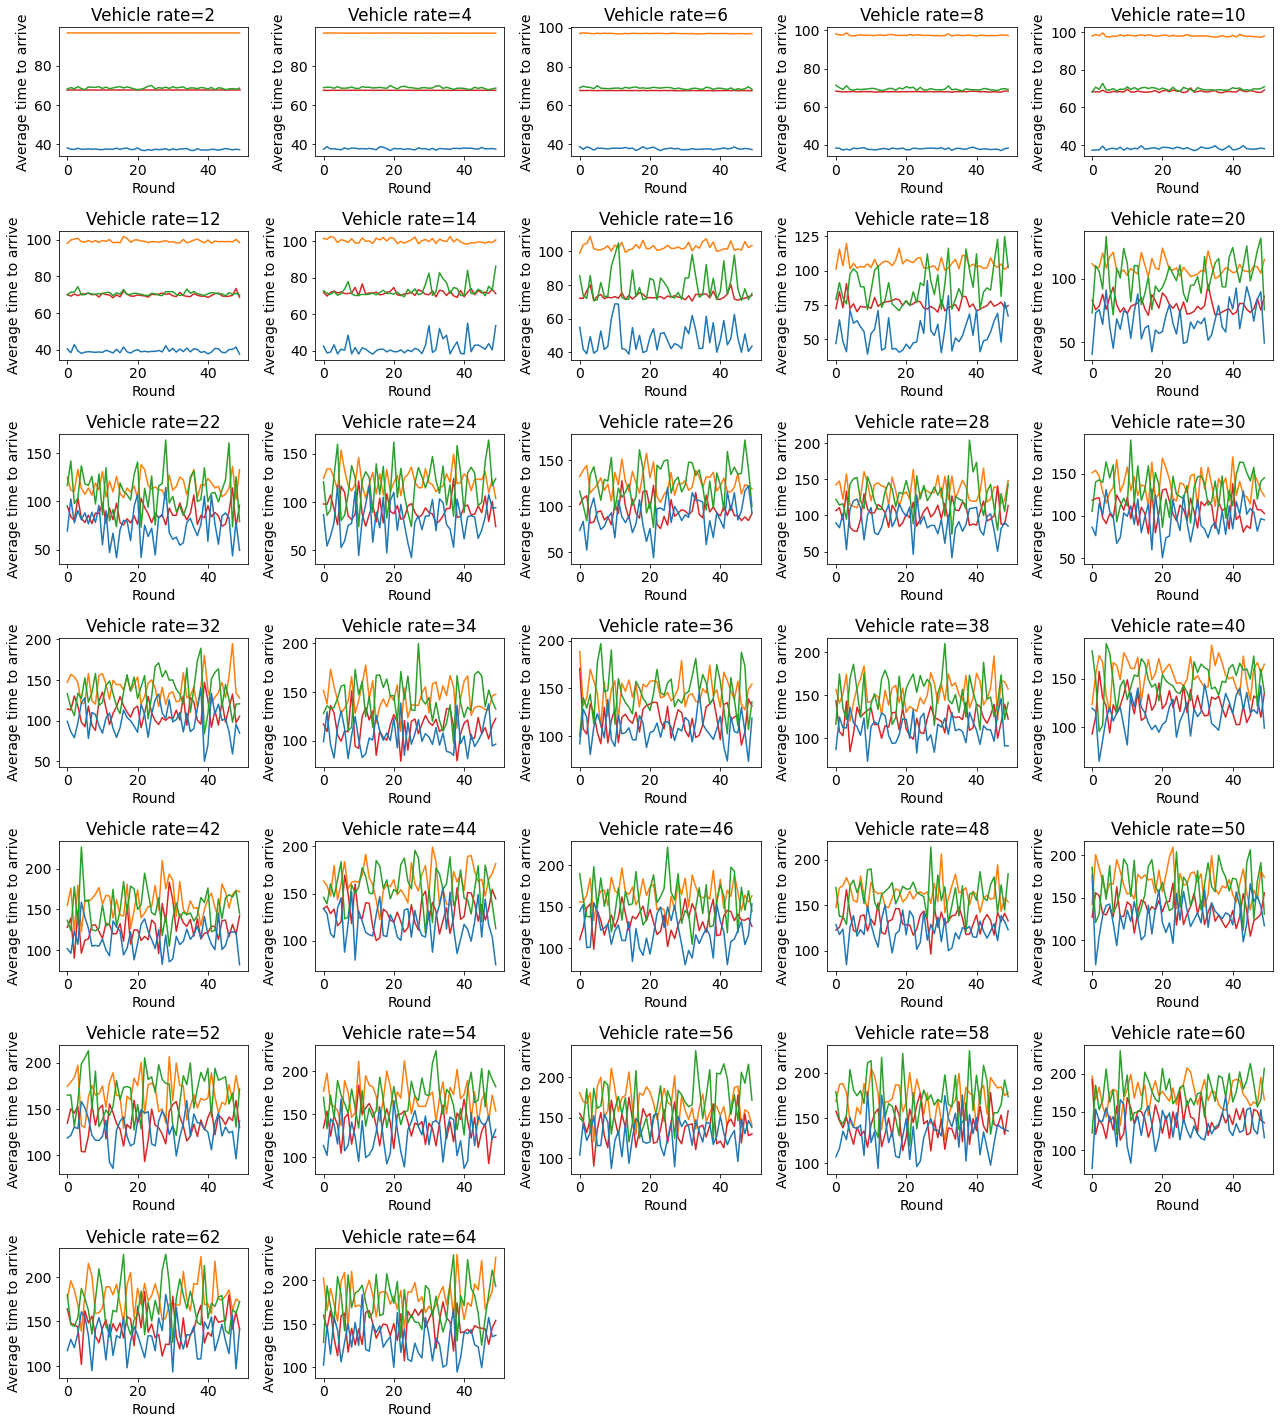

In [184]:
fig, axs = plt.subplots(row, col, figsize=(width, height))

for idx in range(len(rate_range)):
    i = rate_range[idx]
    record_df = pd.read_csv(f'1.1 Zero alpha/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    record_df = preprocess_record(record_df, all_routes)

    ax = route_avg_time(axs[idx//col, idx%col], 
                        fig,
                        record_df=record_df, 
                        number_of_routes=len(all_routes),
                        rate=i,
                       )
    axs[idx//col, idx%col] = ax

for g in range(1, row*col-idx):    
    axs[row-1, col-g].axis('off')
    
plt.tight_layout()
plt.savefig("Analysis/Avg_time_by_route_zero_alpha.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

### No connection case

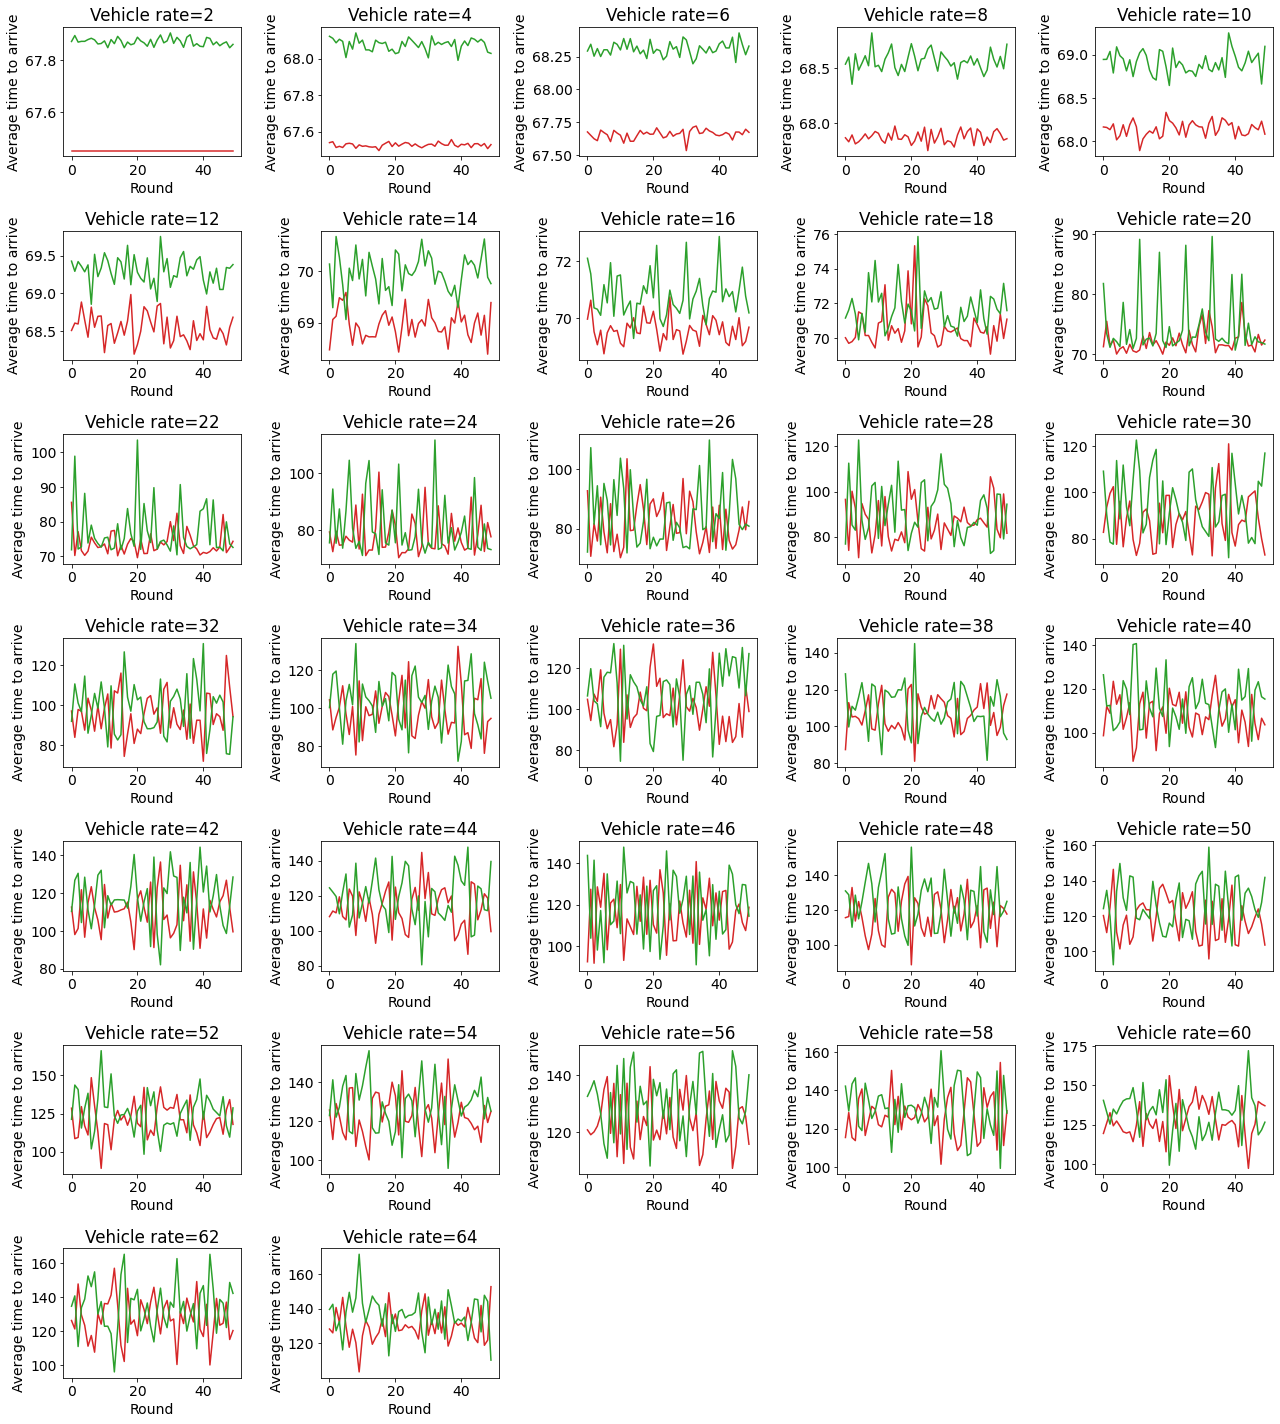

In [160]:
fig2, axs2 = plt.subplots(row, col, figsize=(width, height))

for idx in range(len(rate_range)):
    i = rate_range[idx]
    record_df = pd.read_csv(f'1.2 No connection/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    record_df = preprocess_record(record_df, sub_routes)

    ax = route_avg_time(axs2[idx//col, idx%col], 
                       fig2,
                       record_df=record_df, 
                       number_of_routes=len(sub_routes),
                       rate=i,
                      )
    axs2[idx//col, idx%col] = ax

for g in range(1, row*col-idx):    
    axs2[row-1, col-g].axis('off')

plt.tight_layout()
plt.savefig("Analysis/Avg_time_by_route_no_connection.png", 
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

## - The number of vehicles that choose a route over time

### Zero alpha case

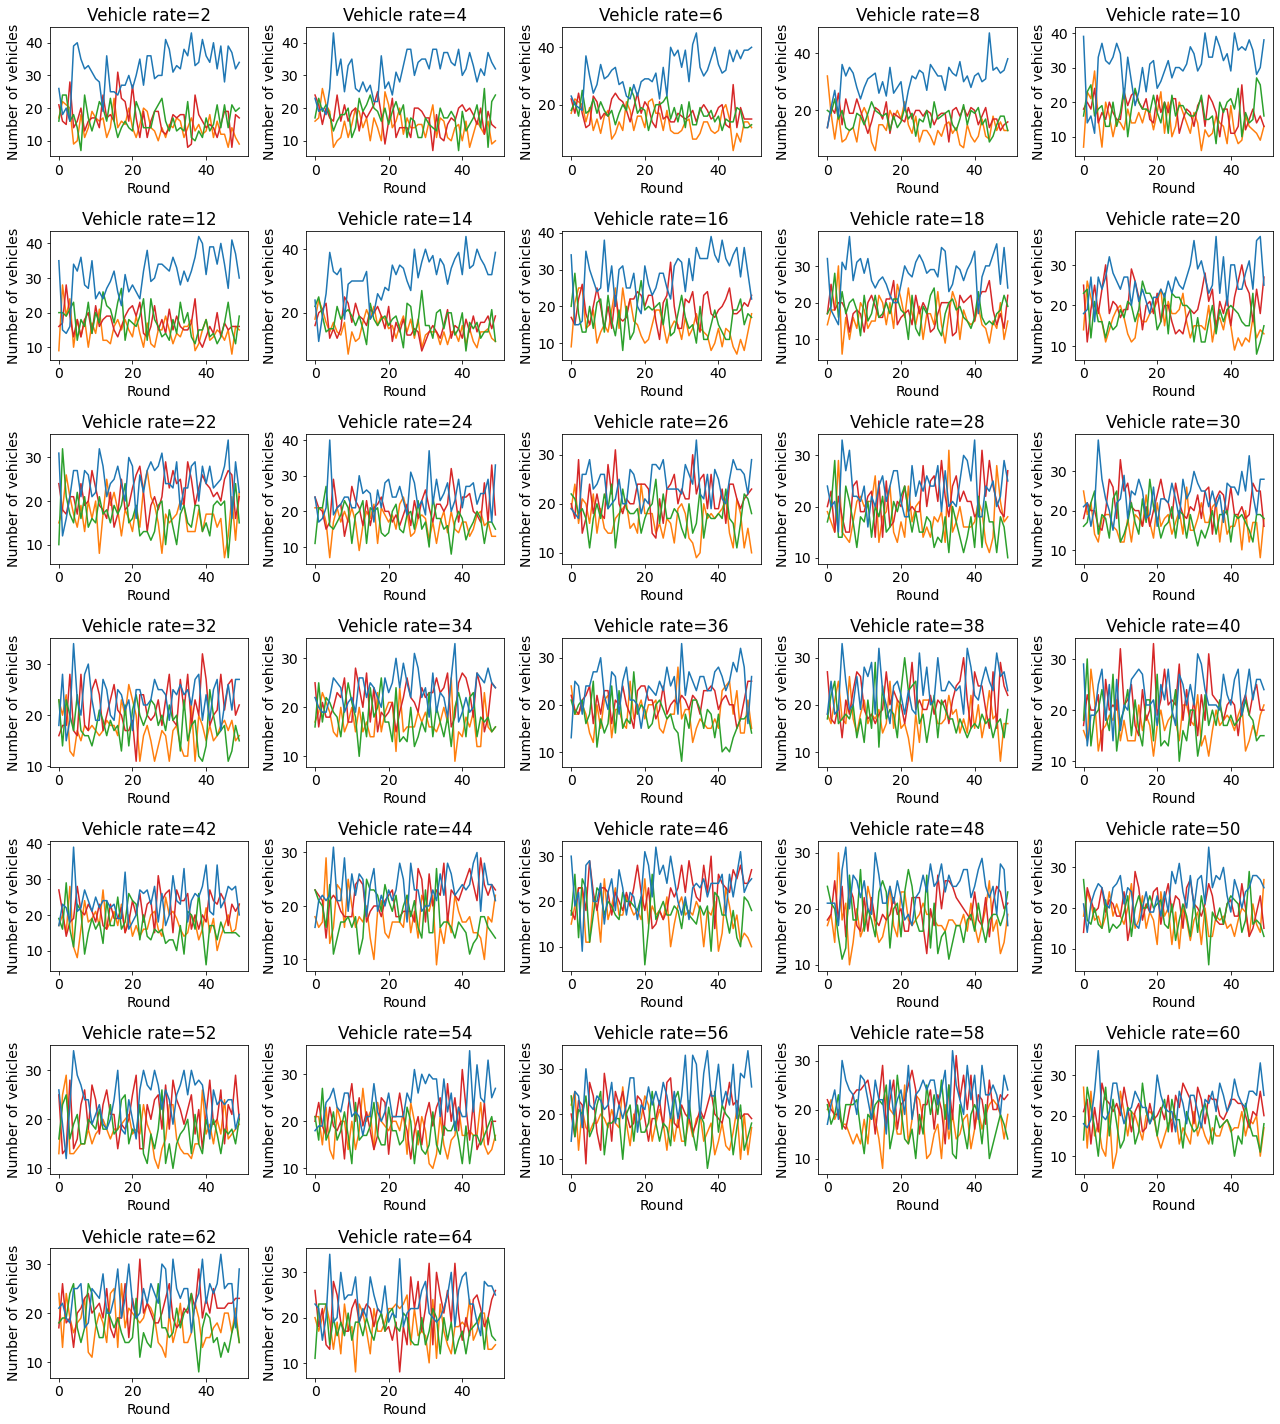

In [185]:
fig3, axs3 = plt.subplots(row, col, figsize=(width, height))

for idx in range(len(rate_range)):
    i = rate_range[idx]
    utility_df = pd.read_csv(f'1.1 Zero alpha/Saved_data/Utility_data/{i}/Round_{rounds}.csv')
    utility_df = preprocess_utility(utility_df)
    
    ax = route_taken_number(axs3[idx//col, idx%col], 
                            fig3,
                            utility_df,
                            rounds, 
                            len(all_routes),
                            i
                           )
    axs3[idx//col, idx%col] = ax

for g in range(1, row*col-idx):    
    axs3[row-1, col-g].axis('off')

plt.tight_layout()
plt.savefig("Analysis/Vehicle_number_by_route_zero_alpha.png",
            bbox_inches='tight', pad_inches=0.25)
plt.show()

### No connection case

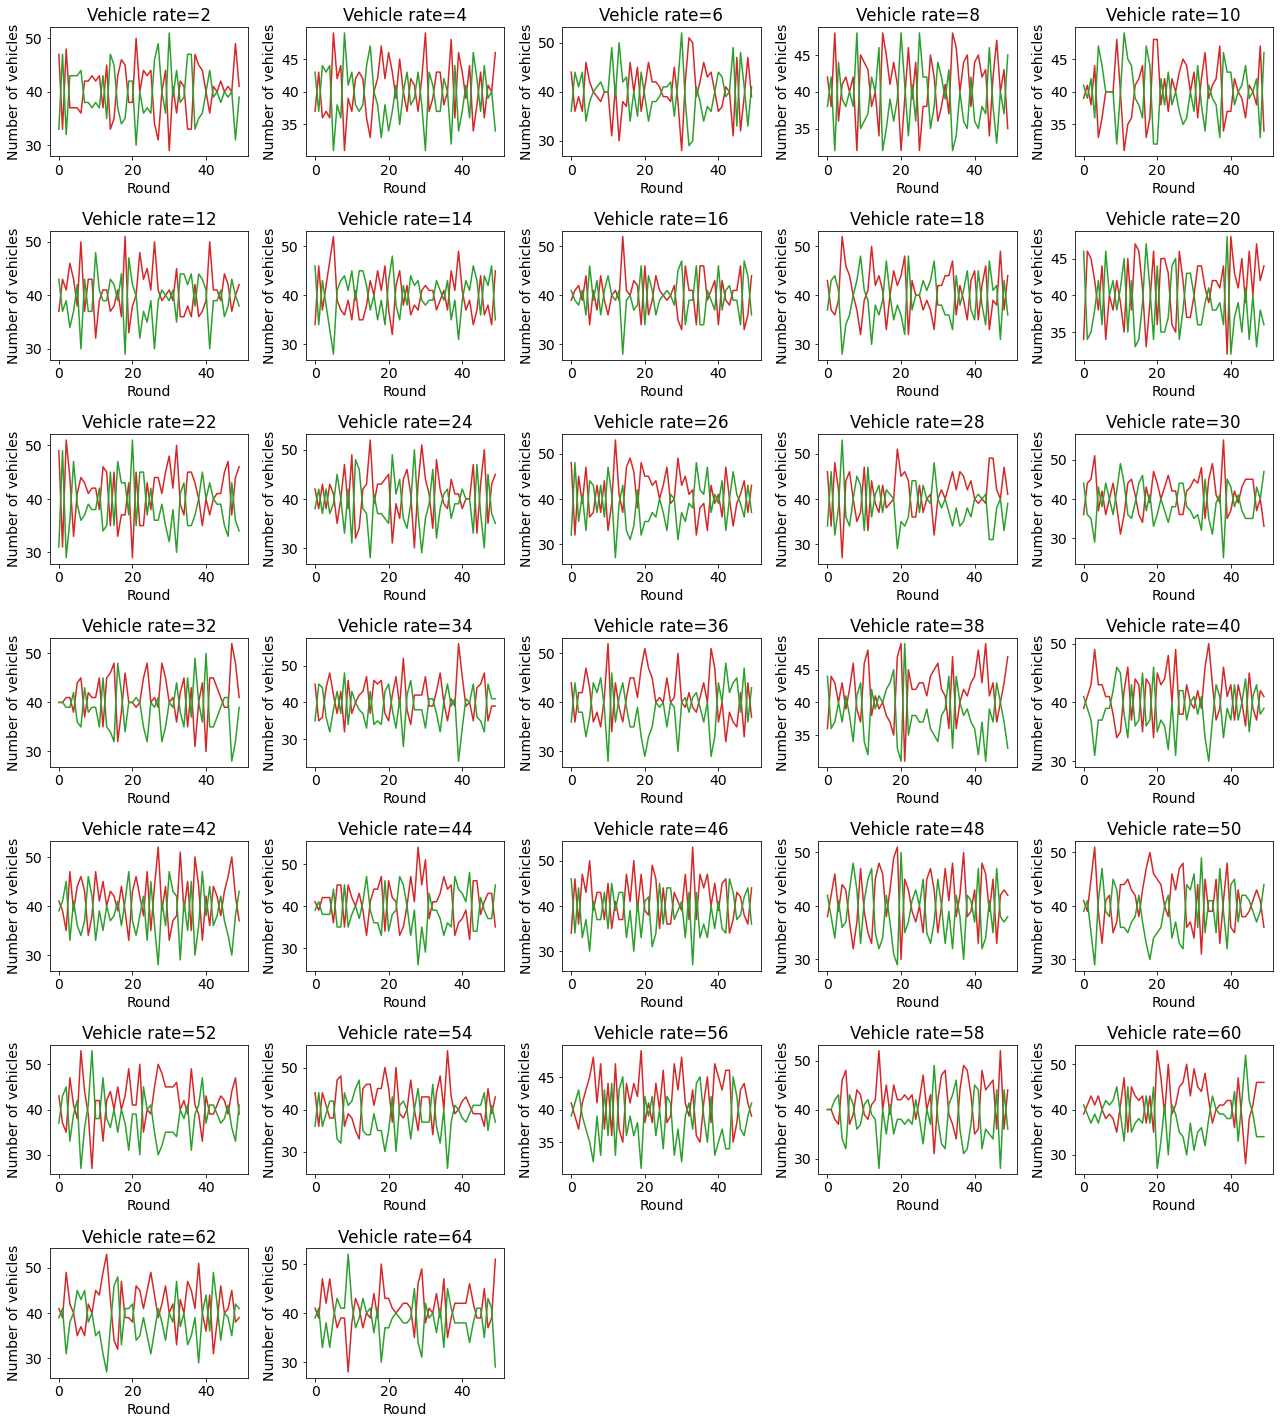

In [163]:
fig4, axs4 = plt.subplots(row, col, figsize=(width, height))

for idx in range(len(rate_range)):
    i = rate_range[idx]
    utility_df = pd.read_csv(f'1.2 No connection/Saved_data/Utility_data/{i}/Round_{rounds}.csv')
    utility_df = preprocess_utility(utility_df)
    
    ax = route_taken_number(axs4[idx//col, idx%col], 
                            fig4,
                            utility_df,
                            rounds, 
                            len(sub_routes),
                            i
                           )
    axs4[idx//col, idx%col] = ax

for g in range(1, row*col-idx):    
    axs4[row-1, col-g].axis('off')
    
plt.tight_layout()
plt.savefig("Analysis/Vehicle_number_by_route_no_connection.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

## - The probabilities of choosing different routes over time

### Zero alpha case

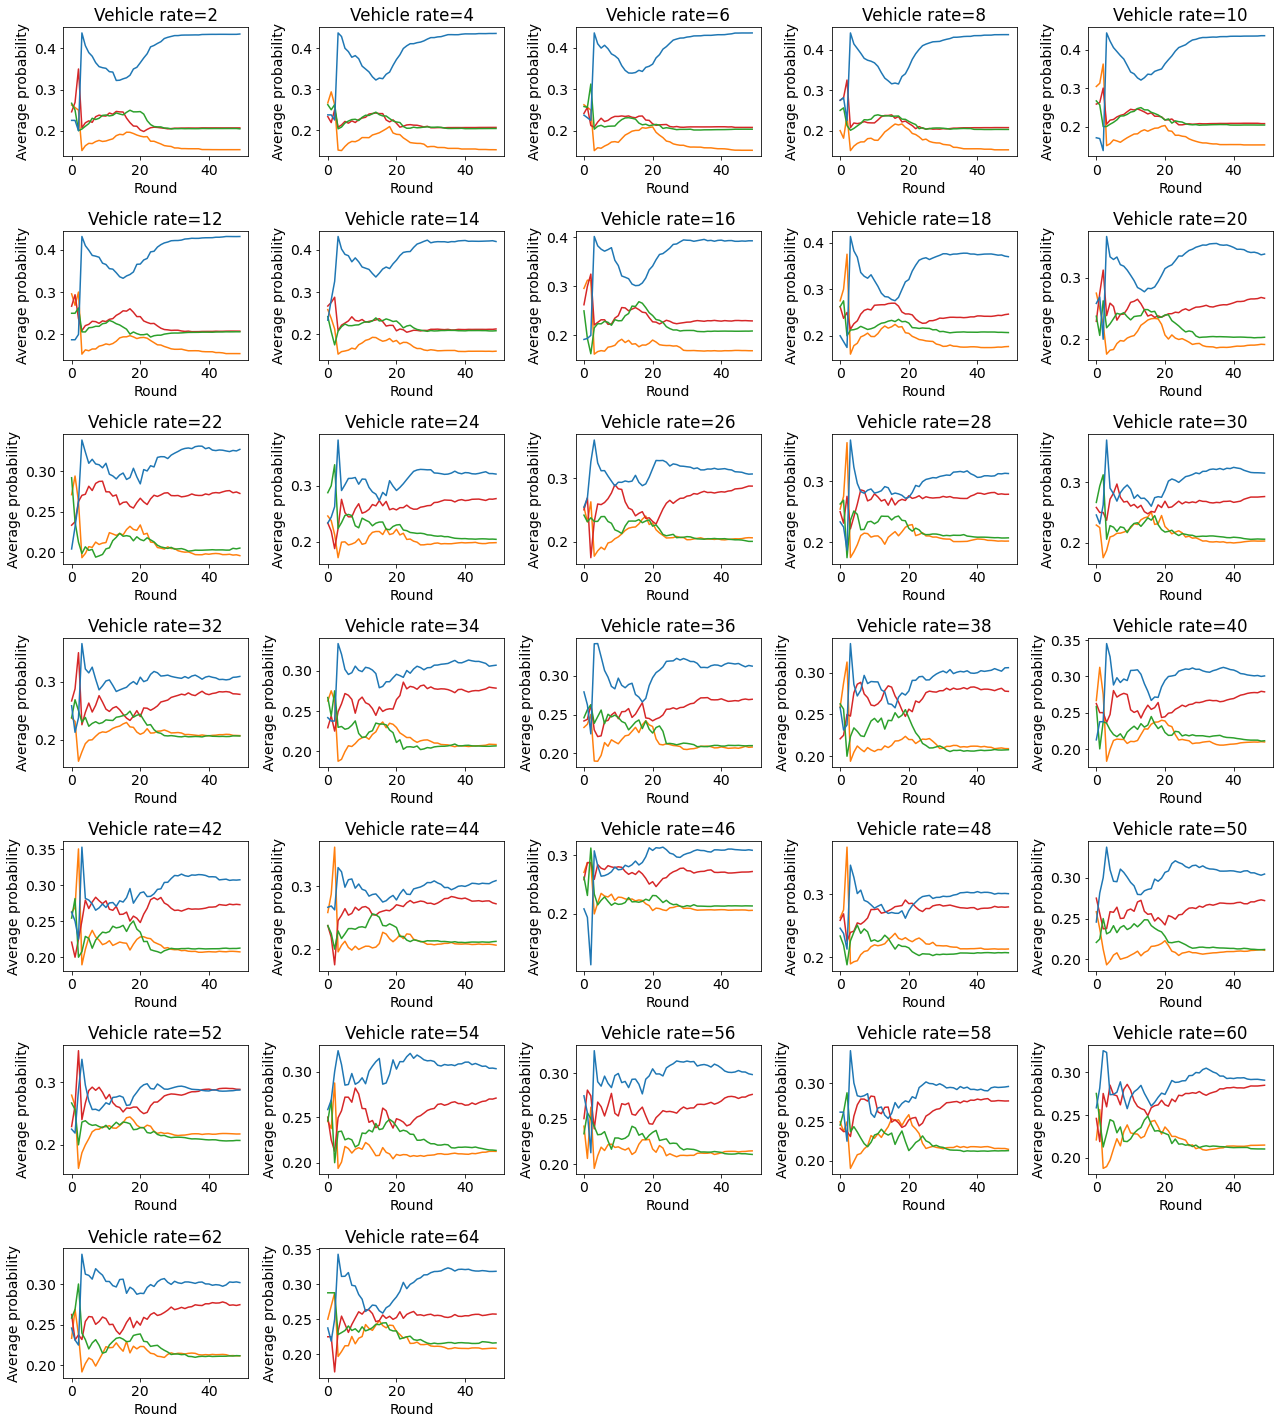

In [186]:
fig5, axs5 = plt.subplots(row, col, figsize=(width, height))

for idx in range(len(rate_range)):
    i = rate_range[idx]
    
    ax = route_chosen_probability(axs5[idx//col, idx%col], 
                                  fig5,
                                  rounds,
                                  len(all_routes),
                                  i,
                                  "1.1 Zero alpha"
                                 )
    axs5[idx//col, idx%col] = ax

for g in range(1, row*col-idx):    
    axs5[row-1, col-g].axis('off')

plt.tight_layout()
plt.savefig("Analysis/Average_probability_by_route_zero_alpha.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

### No connection case

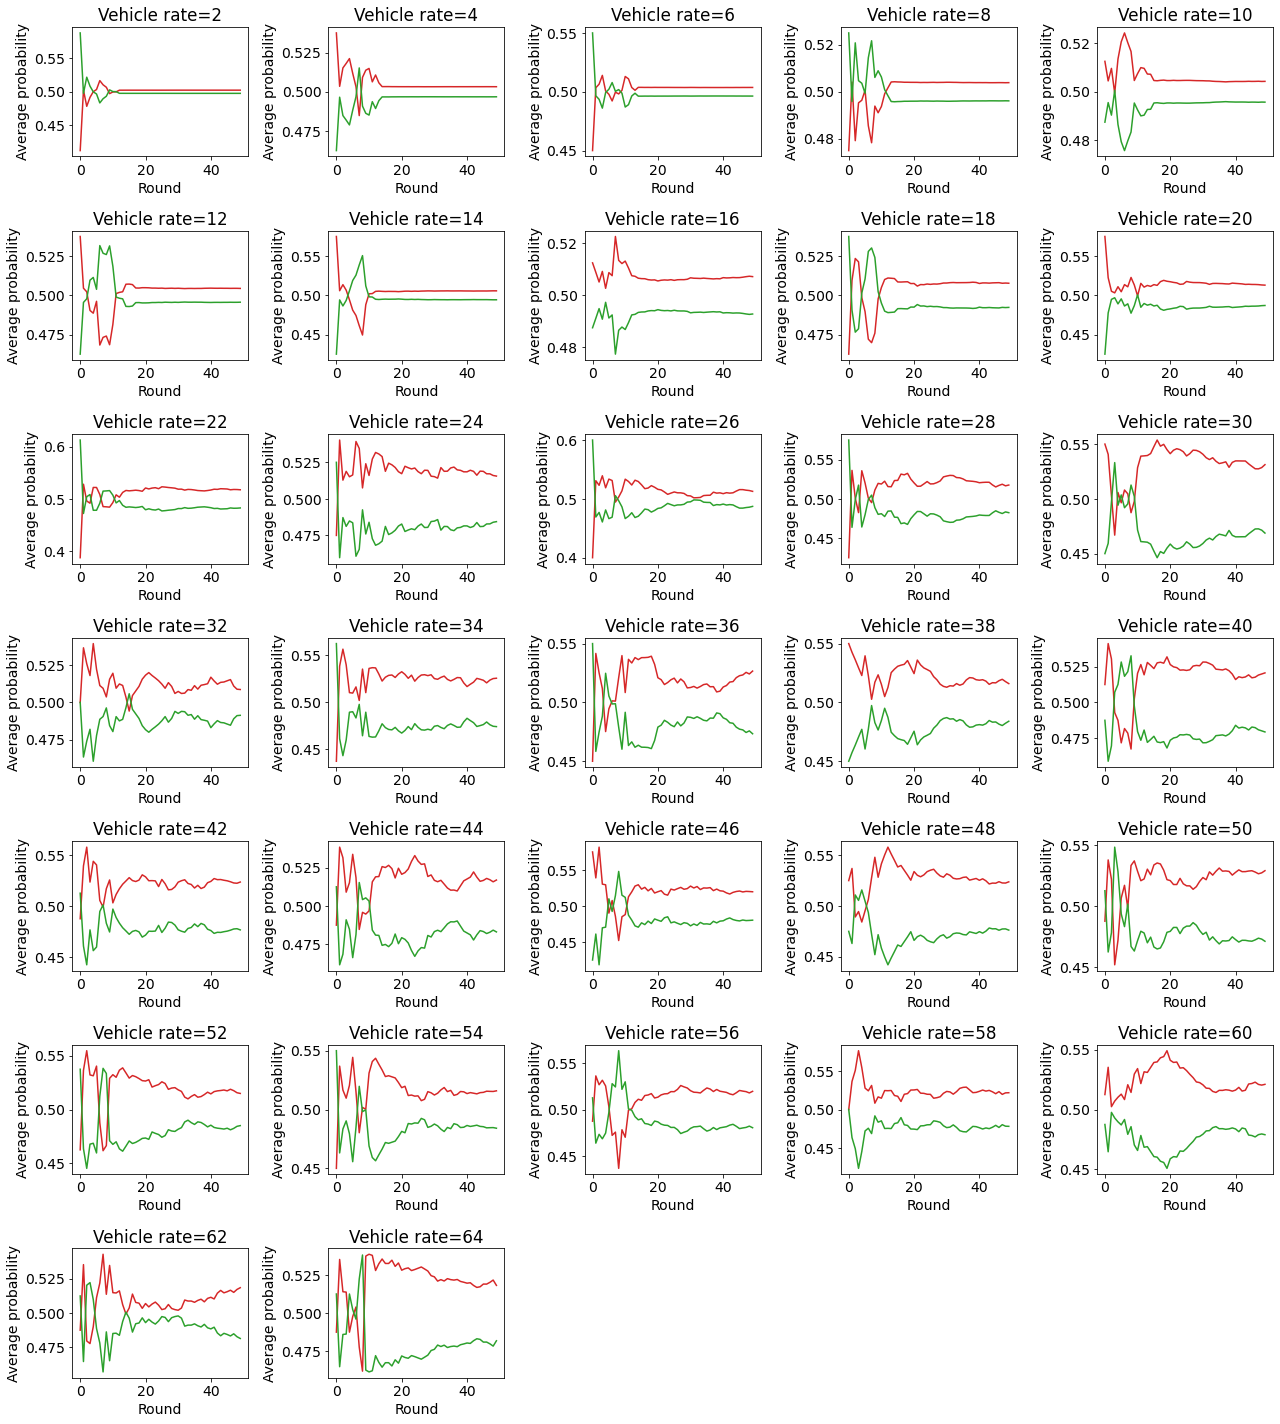

In [165]:
fig6, axs6 = plt.subplots(row, col, figsize=(width, height))

for idx in range(len(rate_range)):
    i = rate_range[idx]
    
    ax = route_chosen_probability(axs6[idx//col, idx%col], 
                                  fig6,
                                  rounds,
                                  len(sub_routes),
                                  i,
                                  "1.2 No connection"
                                 )
    axs6[idx//col, idx%col] = ax

for g in range(1, row*col-idx):    
    axs6[row-1, col-g].axis('off')    

plt.tight_layout()
plt.savefig("Analysis/Average_probability_by_route_no_connection.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

## - The average travel time per vehicle and traffic flux in the last few rounds

In [187]:
# Compute the last 15 rounds' average total time spent per round for each vehicle rate when
# there is a middle connection in the topology
avg_times = []
for i in rate_range:
    df = pd.read_csv(f'1.1 Zero alpha/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    avg_time = avg_total_time(df, target_number_of_rounds, rounds)
    avg_times.append(avg_time/vehicle_limit)

In [18]:
# Compute the last 15 rounds' average total time spent per round for each vehicle rate when
# there is no middle connection in the topology
opt_avg_times = []
for i in rate_range:
    df = pd.read_csv(f'1.2 No connection/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    opt_avg_time = avg_total_time(df, target_number_of_rounds, rounds)
    opt_avg_times.append(opt_avg_time/vehicle_limit)

### Average travel time

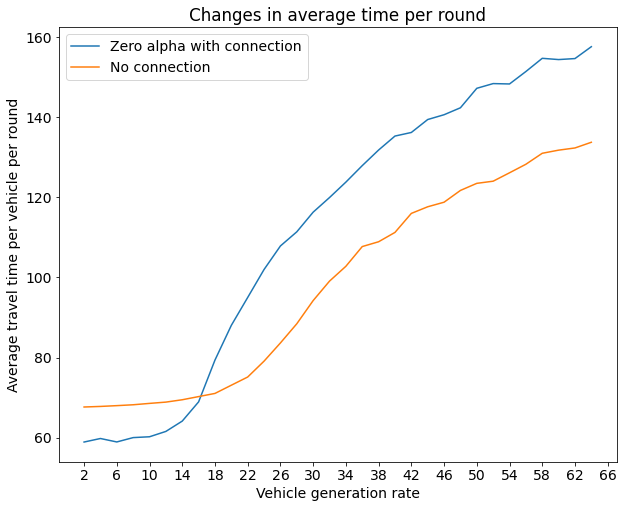

In [199]:
plt.rcParams["figure.figsize"] = (10,8)

# For each vehicle rate, compare the average travel time per vehicle in each round
plt.plot(rate_range, avg_times, label='Zero alpha with connection')
plt.plot(rate_range, opt_avg_times, label='No connection')

plt.xlabel("Vehicle generation rate")
plt.ylabel("Average travel time per vehicle per round")
plt.title("Changes in average time per round")
plt.xticks(np.arange(min(rate_range), max(rate_range)+4, 4))

plt.legend()
plt.savefig("Analysis/Change_in_avg_travel_time_per_round.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

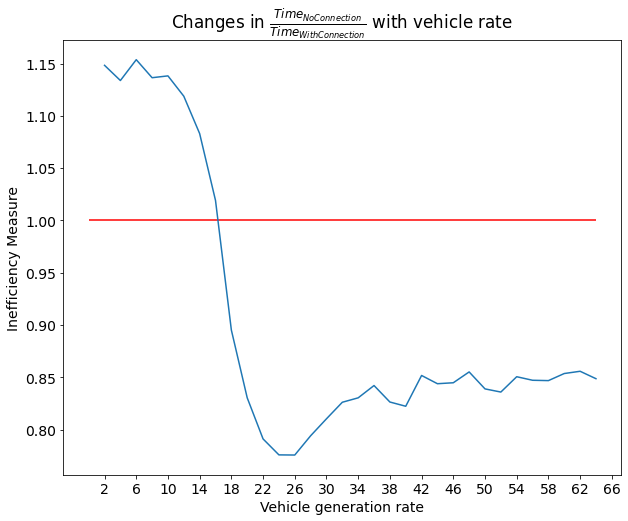

In [189]:
PoA = [opt_avg_times[i] / avg_times[i] for i in range(len(opt_avg_times))]
plt.plot(rate_range, PoA)
plt.hlines(1, 0, 64, color='r')

plt.xlabel("Vehicle generation rate")
plt.ylabel(r"Inefficiency Measure")
plt.title(r"Changes in $\frac{Time_{NoConnection}}{Time_{WithConnection}}$ with vehicle rate")
plt.xticks(np.arange(min(rate_range), max(rate_range)+4, 4))

plt.savefig("Analysis/Changes_in_Inefficiency_with_rate.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

In [27]:
print(f"The position of the vehicle rate that causes the most "+\
      f"inefficiency is {PoA.index(min(PoA))}, and the corresponding "+\
      f"vehicle rate is {rate_range[PoA.index(min(PoA))]}.")

The position of the vehicle rate that causes the most inefficiency is 12, and the corresponding vehicle rate is 26.


In [28]:
sorted_PoA_idx = sorted(range(len(PoA)), key=lambda k: PoA[k])
[[rate_range[sorted_PoA_idx[k]], PoA[sorted_PoA_idx[k]]] for k in range(3)]

[[26, 0.7756600450270343], [24, 0.7758048828332456], [22, 0.7910632268366367]]

In [29]:
slopes = []
for i in range(len(PoA)-1):
    slope = (PoA[i+1] - PoA[i])/2
    slopes.append(slope)

sorted_slope_idx = sorted(range(len(slopes)), key=lambda k: slopes[k])
[[rate_range[sorted_slope_idx[k]], PoA[sorted_slope_idx[k]]] for k in range(10)]

[[16, 1.0191042495592322],
 [18, 0.8951627637390002],
 [14, 1.0829985656525734],
 [20, 0.8303660307000214],
 [12, 1.1187440232754677],
 [6, 1.1697718144667253],
 [10, 1.1381828570717],
 [48, 0.8551159091467876],
 [36, 0.8421096710909854],
 [22, 0.7910632268366367]]

### Traffic flux

In [175]:
target_number_of_rounds = 15
round_times = []

for i in rate_range:
    df = pd.read_csv(f'1.1 Zero alpha/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    
    round_time = df.loc[(df.Vehicle_label==(vehicle_limit-1)) & \
                        (df.Round_number>(rounds-target_number_of_rounds))].Total_time.mean()
    round_time += (vehicle_limit-1) * 60/i
    round_times.append(round_time)

In [46]:
opt_round_times = []

for i in rate_range:
    df = pd.read_csv(f'1.2 No connection/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    
    round_time = df.loc[(df.Vehicle_label==(vehicle_limit-1)) & \
                        (df.Round_number>(rounds-target_number_of_rounds))].Total_time.mean()
    round_time += (vehicle_limit-1) * 60/i
    opt_round_times.append(round_time)

In [169]:
# plt.plot(rate_range, round_times, label="Zero alpha with connection")
# plt.plot(rate_range, opt_round_times, label="No connection")
# plt.legend()
# plt.show()

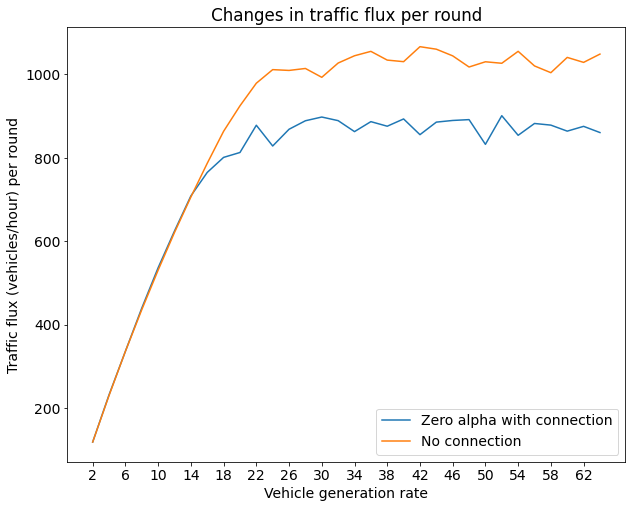

In [200]:
flux = [3600/t * 80 for t in round_times]
opt_flux = [3600/t * 80 for t in opt_round_times]

# For each vehicle rate, compare the total time spent on average for each round
plt.plot(rate_range, flux, label='Zero alpha with connection')
plt.plot(rate_range, opt_flux, label='No connection')

plt.xlabel("Vehicle generation rate")
plt.ylabel("Traffic flux (vehicles/hour) per round")
plt.title("Changes in traffic flux per round")
plt.xticks(np.arange(min(rate_range), max(rate_range)+1, 4))

plt.legend()
plt.savefig("Analysis/Change_in_flux_per_round.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

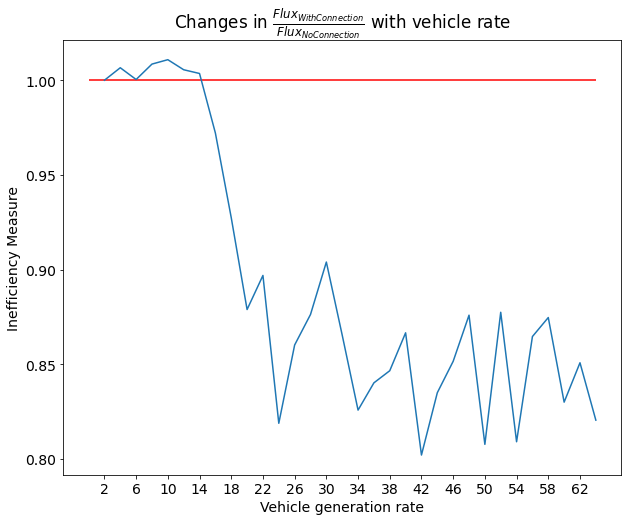

In [191]:
PoA = [flux[i] / opt_flux[i] for i in range(len(opt_avg_times))]
plt.plot(rate_range, PoA)
plt.hlines(1, 0, 64, color='r')

plt.xlabel("Vehicle generation rate")
plt.ylabel(r"Inefficiency Measure")
plt.title(r"Changes in $\frac{Flux_{WithConnection}}{Flux_{NoConnection}}$ with vehicle rate")
plt.xticks(np.arange(min(rate_range), max(rate_range)+1, 4))
plt.savefig("Analysis/Changes_in_Flux_Inefficiency_with_rate.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

## - Traffic density vs. traffic flux

In [140]:
# record_df = pd.read_csv(f'1.1 Zero alpha/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
# record_df = preprocess_record(record_df, all_routes)
# record_df.loc[(record_df.Round_number==25) & (record_df.Road_order_label==2)]

In [51]:
def compute_density(record_df, 
                    target_round, 
                    rate,
                    road_length = 0.15):
    sub_record = record_df.loc[(record_df.Round_number==target_round)].reset_index(drop=True)
    pivot_df = pd.pivot_table(sub_record, values='Total_time', 
                              index=['Vehicle_label', 'Road_order_label'], 
                              aggfunc=np.mean).reset_index(drop=False)
    road_density = {}
    
    for o in pivot_df.Road_order_label.unique():
        starts, ends = [], []
        df_tmp = pivot_df.loc[pivot_df.Road_order_label==o].reset_index(drop=True)

        for idx, row in df_tmp.iterrows():
            label = df_tmp.at[idx, "Vehicle_label"]
            time = df_tmp.at[idx, "Total_time"]
            
            start_time = (label-1) * 60/rate
            end_time = start_time + time

            starts.append(start_time)
            ends.append(end_time)
            
        num_points = len(starts)
        max_cnt = 0
        
        for k in np.arange(min(starts), max(ends)+0.5, 0.5):
            cnt = 0
            for i in range(num_points):
                if starts[i] <= k and ends[i] >= k:
                    cnt += 1
            if cnt > max_cnt:
                max_cnt = cnt
        road_density[o] = [max_cnt / road_length]
                
    return road_density

In [192]:
all_road_density = []
target_number_of_rounds = 15

for idx in range(len(rate_range)):
    i = rate_range[idx]
    record_df = pd.read_csv(f'1.1 Zero alpha/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    record_df = preprocess_record(record_df, all_routes)
    
    road_density = compute_density(record_df, rounds, i)
    for j in range(1, target_number_of_rounds):
        for k in road_density.keys():
#             print(road_density)
            road_density[k].append(compute_density(record_df, rounds-j, i)[k][0])
            
    for k in road_density.keys():
        road_density[k] = sum(road_density[k]) / target_number_of_rounds
    
    all_road_density.append(road_density)

In [57]:
opt_all_road_density = []

for idx in range(len(rate_range)):
    i = rate_range[idx]
    record_df = pd.read_csv(f'1.2 No connection/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    record_df = preprocess_record(record_df, sub_routes)
    
    road_density = compute_density(record_df, rounds, i)
    for j in range(1, target_number_of_rounds):
        for k in road_density.keys():
#             print(road_density)
            road_density[k].append(compute_density(record_df, rounds-j, i)[k][0])
            
    for k in road_density.keys():
        road_density[k] = sum(road_density[k]) / target_number_of_rounds
    
    opt_all_road_density.append(road_density)

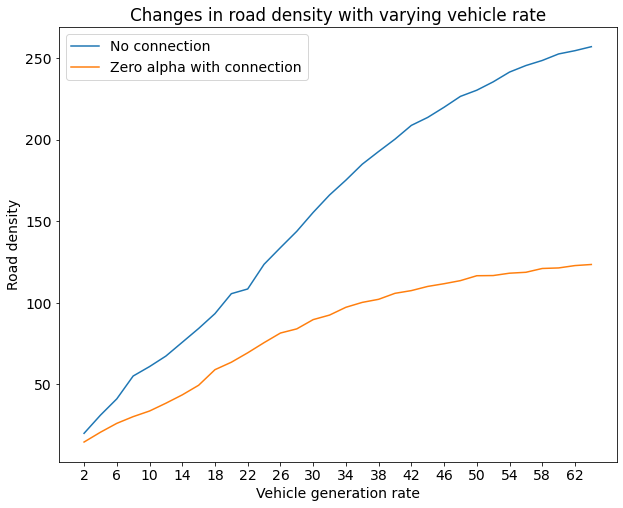

In [193]:
opt_avg_density_l, avg_density_l = [], []
for idx in range(len(rate_range)):
    opt_avg_density = (opt_all_road_density[idx][0] + opt_all_road_density[idx][1]) / 2
    avg_density = (all_road_density[idx][0] + all_road_density[idx][1] + \
                   all_road_density[idx][2] + all_road_density[idx][3]) / 4
    
    opt_avg_density_l.append(opt_avg_density)
    avg_density_l.append(avg_density)
    
plt.plot(rate_range, opt_avg_density_l, label="No connection")
plt.plot(rate_range, avg_density_l, label="Zero alpha with connection")

plt.xlabel("Vehicle generation rate")
plt.ylabel("Road density")
plt.title('Changes in road density with varying vehicle rate')
plt.legend()

plt.xticks(np.arange(min(rate_range), max(rate_range)+1, 4))
plt.savefig("Analysis/Changes_in_Density_with_rate.png",
            bbox_inches = 'tight', pad_inches=0.25)

plt.show()

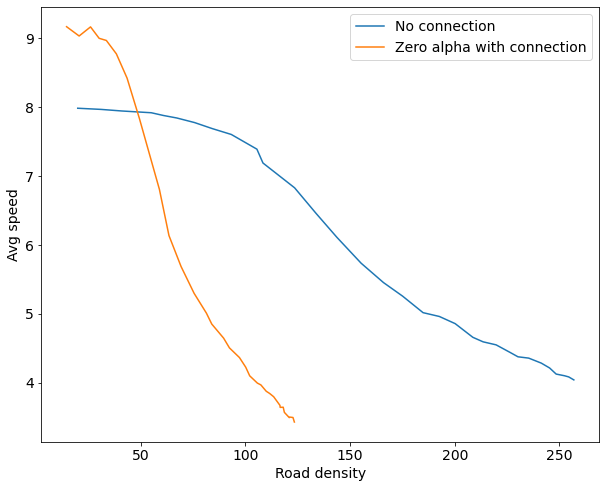

In [206]:
avg_speed = [0.15*3600/t for t in avg_times]
opt_avg_speed = [0.15*3600/t for t in opt_avg_times]

plt.plot(opt_avg_density_l, opt_avg_speed, label="No connection")
plt.plot(avg_density_l, avg_speed, label="Zero alpha with connection")

plt.xlabel("Road density")
plt.ylabel("Avg speed")

plt.legend()
plt.show()

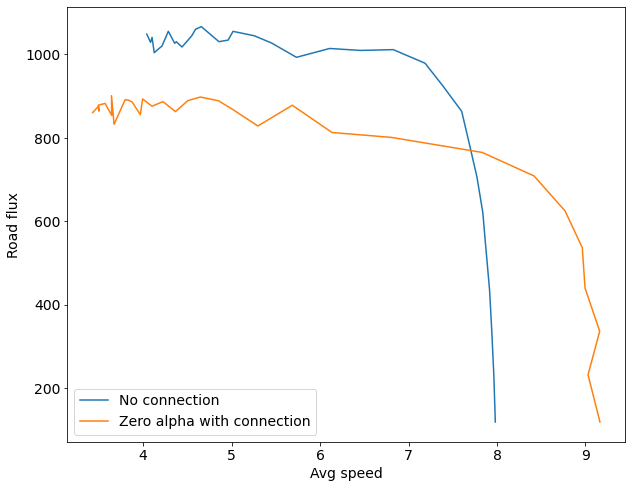

In [207]:
plt.plot(opt_avg_speed, opt_flux, label="No connection")
plt.plot(avg_speed, flux, label="Zero alpha with connection")

plt.xlabel("Avg speed")
plt.ylabel("Road flux")

plt.legend()
plt.show()

Text(0.5, 0, 'Flux')

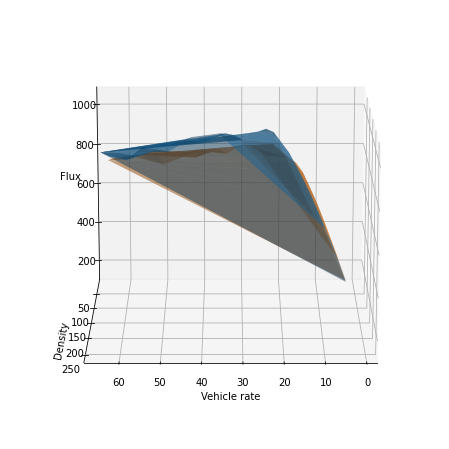

In [195]:
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm

# %matplotlib qt
%matplotlib inline

plt.rcParams["figure.figsize"] = (10,8)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# ax.plot_surface(df1.X, df1.Y, df1.Z)
ax.view_init(15, 90)
ax.plot_trisurf(rate_range, opt_avg_density_l, opt_flux, linewidth=0, alpha=0.5)
ax.plot_trisurf(rate_range, avg_density_l, flux, linewidth=0, alpha=0.5)
# fig.colorbar(surf)

ax.set_xlabel('Vehicle rate')
ax.set_ylabel('Density')
ax.set_zlabel('Flux')

# fig.colorbar(surf, shrink=0.5, aspect=5)

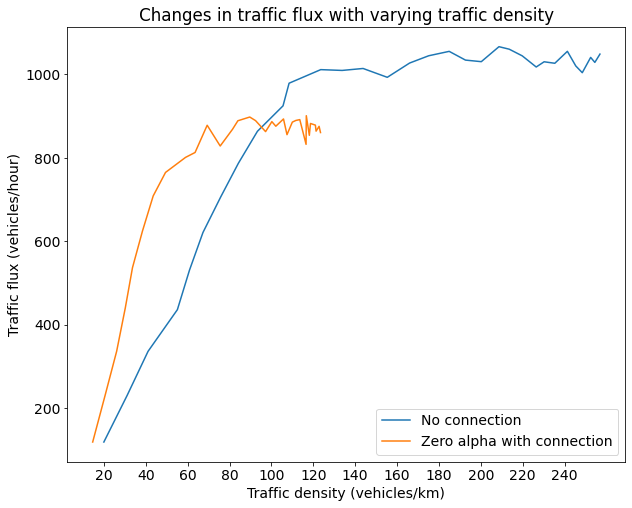

In [203]:
plt.plot(opt_avg_density_l, opt_flux, label="No connection")
plt.plot(avg_density_l, flux, label="Zero alpha with connection")

# xnew = np.linspace(min(opt_avg_density_l), max(opt_avg_density_l), num=101, endpoint=True)
# f_linear = interp1d(opt_avg_density_l, opt_flux)
# plt.plot(xnew, f_linear(xnew), '-', label='linear')


# xnew2 = np.linspace(min(avg_density_l), max(avg_density_l), num=101, endpoint=True)
# f_linear2 = interp1d(avg_density_l, flux, kind='linear')
# plt.plot(xnew2, f_linear2(xnew2), '-', label='linear')

plt.xlabel("Traffic density (vehicles/km)")
plt.ylabel("Traffic flux (vehicles/hour)")
plt.title('Changes in traffic flux with varying traffic density')
plt.xticks(np.arange(min(opt_avg_density_l), max(opt_avg_density_l)+1, 20))

plt.legend()
plt.savefig("Analysis/Changes_in_Density_with_Flux.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

In [99]:
# from scipy.interpolate import interp1d

# xnew = np.linspace(min(opt_avg_density_l), max(opt_avg_density_l), num=51, endpoint=True)

# # Define interpolators.
# f_linear = interp1d(opt_avg_density_l, opt_flux)
# plt.plot(xnew, f_linear(xnew), '-', label='linear')
# f_cubic = interp1d(opt_avg_density_l, opt_flux, kind='cubic')

# # Plot.
# plt.plot(opt_avg_density_l, opt_flux, 'o', label='data')
# plt.plot(xnew, f_linear(xnew), '-', label='linear')
# plt.plot(xnew, f_cubic(xnew), '--', label='cubic')

### Visualize overlapping intervals (for computing density)

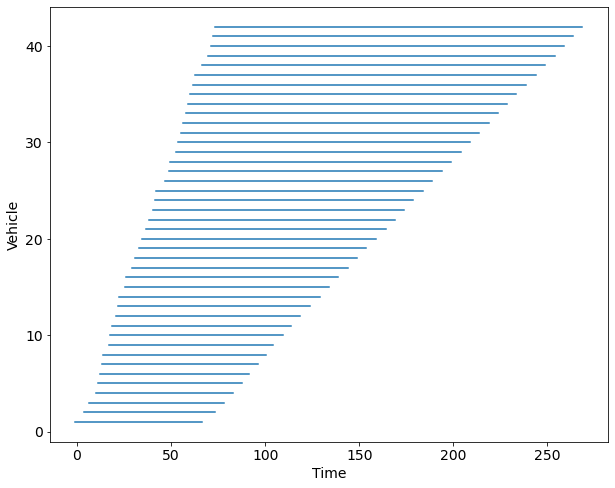

In [120]:
sub_record = record_df.loc[(record_df.Round_number==25) & (record_df.Road_order_label==0)].reset_index(drop=True)
rate = record_df.at[0, "vehicle_rate"]
x_ranges, y_ranges, interval_points = [], [], []

for idx, row in sub_record.iterrows():
    label = sub_record.at[idx, "Vehicle_label"]
    time = sub_record.at[idx, "Total_time"]
    start_time = (label-1) * 60/rate
    end_time = start_time + time
    
    interval_points.append([start_time, end_time])
    x_range = np.arange(start_time, end_time+0.5, 0.5)
    x_ranges.append(x_range)
    y_ranges.append(np.ones((len(x_range)))*(idx+1))
    
for i in range(len(x_ranges)):
    plt.plot(x_ranges[i], y_ranges[i], "tab:blue")
    
plt.xlabel("Time")
plt.ylabel("Vehicle")
plt.show()

In [121]:
starts = [p[0] for p in interval_points]
ends = [p[1] for p in interval_points]
num_points = len(interval_points)

max_cnt = 0

for k in np.arange(min(starts), max(ends)+0.5, 0.5):
    cnt = 0
    for i in range(num_points):
        if starts[i] <= k and ends[i] >= k:
            cnt += 1
    if cnt > max_cnt:
        max_cnt = cnt
        
max_cnt, len(starts)

(40, 42)

## - The total utility of all vehicles in the last few rounds

### Zero alpha case

In [180]:
# Compute the average utility value for each vehicle in each round for the last 15 rounds
target_number_of_rounds = 15
utilities_0 = []

for i in rate_range:
    total_utilities = total_utility(target_number_of_rounds, 
                                    rounds,
                                    i,
                                    "1.1 Zero alpha"
                                   )
    utilities_0.append(sum(total_utilities)/target_number_of_rounds/vehicle_limit)

### No connection case

In [123]:
utilities_no = []

for i in rate_range:
    total_utilities = total_utility(target_number_of_rounds, 
                                    rounds,
                                    i,
                                    "1.2 No connection"
                                   )
    utilities_no.append(sum(total_utilities)/target_number_of_rounds/vehicle_limit)

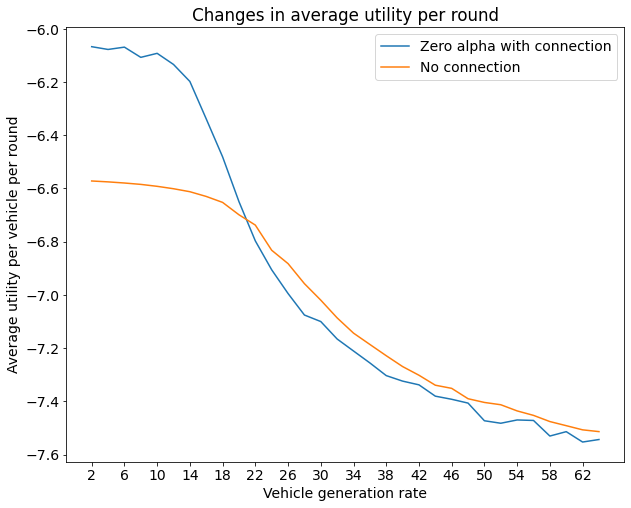

In [204]:
plt.plot(rate_range, utilities_0, label='Zero alpha with connection')
plt.plot(rate_range, utilities_no, label='No connection')

plt.xlabel("Vehicle generation rate")
plt.ylabel("Average utility per vehicle per round")
plt.title("Changes in average utility per round")
plt.xticks(np.arange(min(rate_range), max(rate_range)+1, 4))

plt.legend()
plt.savefig("Analysis/Change_in_avg_utility_per_round.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

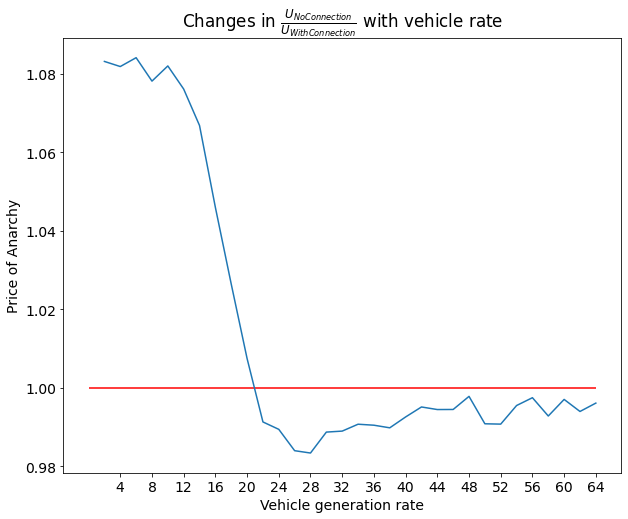

In [205]:
PoA2 = [1/(utilities_0[i] / utilities_no[i]) for i in range(len(utilities_0))]
plt.plot(rate_range, PoA2)
plt.hlines(1, 0, 64, color='r')

plt.xlabel("Vehicle generation rate")
plt.ylabel(r"Price of Anarchy")
plt.title(r"Changes in $\frac{U_{NoConnection}}{U_{WithConnection}}$ with vehicle rate")
plt.xticks(np.arange(min(rate_range+2), max(rate_range)+1, 4))
# plt.savefig("Analysis/Changes_in_utility_Inefficiency_with_rate.png",
#             bbox_inches = 'tight', pad_inches=0.25)

plt.show()

In [49]:
sorted_PoA_idx2 = sorted(range(len(PoA2)), key=lambda k: PoA2[k])
[[rate_range[sorted_PoA_idx2[k]], PoA2[sorted_PoA_idx2[k]]] for k in range(10)]

[[28, 0.9833289623755869],
 [26, 0.9839261783915134],
 [30, 0.9886696502035855],
 [32, 0.9889223532519871],
 [24, 0.9893697095003295],
 [2, 0.9894518814401939],
 [38, 0.9897598003135943],
 [36, 0.9904255901781357],
 [34, 0.990677823134281],
 [52, 0.990703361757738]]

In [50]:
rate_range[7], PoA2[7]

(16, 1.0459790293060376)

In [51]:
# PoA2
slopes2 = []
for i in range(len(PoA2)-1):
    slope = (PoA2[i+1] - PoA2[i])/2
    slopes2.append(slope)

In [52]:
slopes2 = []
for i in range(len(PoA2)-1):
    slope = (PoA2[i+1] - PoA2[i])/2
    slopes2.append(slope)

sorted_slope_idx2 = sorted(range(len(slopes2)), key=lambda k: slopes2[k])
[[rate_range[sorted_slope_idx2[k]], PoA2[sorted_slope_idx2[k]]] for k in range(10)]

[[14, 1.0668665777098254],
 [16, 1.0459790293060376],
 [18, 1.0264254563122948],
 [20, 1.0074335864573136],
 [12, 1.076164774226876],
 [48, 0.9977808682857825],
 [10, 1.0820625008484992],
 [24, 0.9893697095003295],
 [56, 0.9974417488763274],
 [60, 0.9970035397562554]]

# Save legend as pic

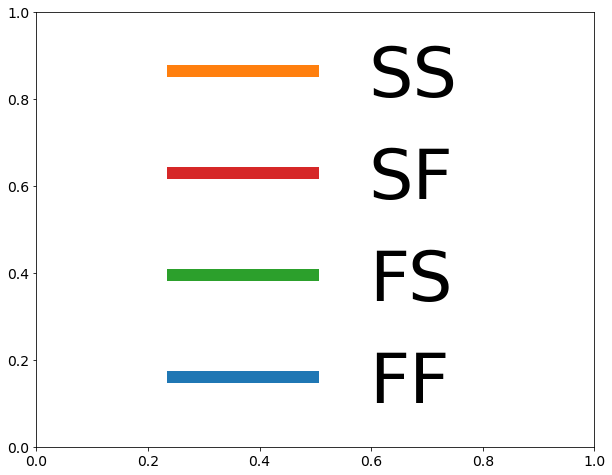

In [147]:
from matplotlib.lines import Line2D

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

colors = ['tab:orange', 'tab:red', 'tab:green', 'tab:blue']
labels = ["SS", "SF", "FS", "FF"]
f = lambda c,l: Line2D([0], [0], color=c, label=l, lw=12)

handles = [f(colors[i], labels[i]) for i in range(len(colors))]
legend = plt.legend(handles, labels, loc="center", framealpha=0, frameon=False, prop={"size":70})

export_legend(legend, filename="Legend_all.png")
plt.show()